# Tom and Jerry Image Classification
https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification

## Import libraries

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import os
import squarify



# import statsmodels.api as sm

import networkx as nx
# import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input


import matplotlib.image as mpimg

## Function to extract features of an image

### General function

## Initialize

In [8]:
data_dir = './kaggle/input/tom_and_jerry/tom_and_jerry'
image_size = (224, 224)

data = []
labels = []


subfolders = ['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']

label_categories = ["Jerry","Tom","None","Both"]

### Tom & Jerry Label Balance

[1240, 1930, 1528, 780]

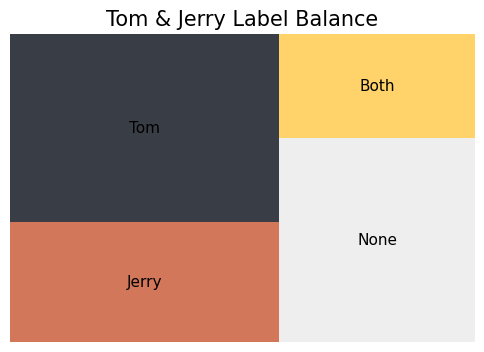

In [3]:
# Get the number of images for each class
image_counts = [len(os.listdir(os.path.join(data_dir, label))) for label in subfolders]

# Create a squarify plot of the class distribution
fig = plt.subplots(figsize = (6, 4))
# jerry, tom, none, both
colors = [ '#d27759','#393E46', '#EEEEEE',  '#FFD369']

squarify.plot(image_counts, label = label_categories, color = colors, text_kwargs = {"fontsize": 11})

plt.title("Tom & Jerry Label Balance", fontsize = 15)
plt.axis("off")
image_counts

### Load data

In [4]:
for label, subfolder in enumerate(subfolders):
    folder_path = os.path.join(data_dir, subfolder)
    image_files = os.listdir(folder_path)
    for image_file in image_files:
        data.append(os.path.join(subfolder, image_file))
        labels.append(label)

        
# Create a DataFrame from the data and labels
df = pd.DataFrame({'image_path': data, 'label': labels})

In [5]:
df

,image_path,label
0,jerry/frame4473.jpg,0
1,jerry/frame1993.jpg,0
2,jerry/frame3451.jpg,0
3,jerry/frame5203.jpg,0
4,jerry/frame3104.jpg,0
...,...,...
5473,tom_jerry_1/frame2026.jpg,3
5474,tom_jerry_1/frame1566.jpg,3
5475,tom_jerry_1/frame3624.jpg,3
5476,tom_jerry_1/frame3919.jpg,3


### Split dataset into training, validation, and testing sets

In [8]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

## Define a neural network model
**Base model ResNet50**

This section of code was guided by another notebook found at [Tom & Jerry Image Classification](https://www.kaggle.com/code/alioraji/tom-jerry-image-classification)


Initialize model

In [9]:
def create_model(n_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)  # Number of output classes
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

model = create_model(len(subfolders))

Compile model

In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Train the model 

In [11]:
batch_size = 16
epochs = 10
# Data augmentation increases variability by applying horizontal flipping and rotation augmentation.
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=30)
val_datagen = ImageDataGenerator(rescale=1./255)

# Generate training data batches from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=data_dir,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw'
)

# Generate testing data batches from DataFrame
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=data_dir,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw'
)

Found 3943 validated image filenames.
Found 439 validated image filenames.


In [12]:
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

Epoch 1/10
247/247 [==============================] - 663s 3s/step - loss: 0.9139 - accuracy: 0.6546 - val_loss: 4.6477 - val_accuracy: 0.3235
Epoch 2/10
247/247 [==============================] - 661s 3s/step - loss: 0.5451 - accuracy: 0.8106 - val_loss: 1.9441 - val_accuracy: 0.3235
Epoch 3/10
247/247 [==============================] - 687s 3s/step - loss: 0.4560 - accuracy: 0.8534 - val_loss: 2.7235 - val_accuracy: 0.3257
Epoch 4/10
247/247 [==============================] - 675s 3s/step - loss: 0.4036 - accuracy: 0.8707 - val_loss: 2.1647 - val_accuracy: 0.4761
Epoch 5/10
247/247 [==============================] - 656s 3s/step - loss: 0.3668 - accuracy: 0.8851 - val_loss: 0.2406 - val_accuracy: 0.9180
Epoch 6/10
247/247 [==============================] - 643s 3s/step - loss: 0.3405 - accuracy: 0.8864 - val_loss: 0.5544 - val_accuracy: 0.8223
Epoch 7/10
247/247 [==============================] - 647s 3s/step - loss: 0.3399 - accuracy: 0.8925 - val_loss: 0.4346 - val_accuracy: 0.8679

#### Testing Model Performance

In [13]:
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')

28/28 [==============================] - 14s 505ms/step - loss: 0.2087 - accuracy: 0.9226
Validation Loss: 0.20871543884277344
Validation Accuracy: 0.9225512742996216


### Fine-Tuning the model

In [14]:
# Unfreeze all layers in the model
for layer in model.layers:
    layer.trainable = True


# Compile the model again to apply the changes
learning_rate = 0.1e-4 

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Fine-tune the model on the training data
fine_tune_epochs = 5

history_fine_tune = model.fit(train_generator,
                             epochs=epochs + fine_tune_epochs,
                             initial_epoch=history.epoch[-1],
                             validation_data=val_generator)

Epoch 10/15
247/247 [==============================] - 671s 3s/step - loss: 0.2277 - accuracy: 0.9265 - val_loss: 0.1768 - val_accuracy: 0.9362
Epoch 11/15
247/247 [==============================] - 656s 3s/step - loss: 0.1892 - accuracy: 0.9379 - val_loss: 0.1759 - val_accuracy: 0.9385
Epoch 12/15
247/247 [==============================] - 689s 3s/step - loss: 0.1861 - accuracy: 0.9434 - val_loss: 0.1596 - val_accuracy: 0.9431
Epoch 13/15
247/247 [==============================] - 687s 3s/step - loss: 0.1719 - accuracy: 0.9490 - val_loss: 0.1576 - val_accuracy: 0.9453
Epoch 14/15
247/247 [==============================] - 654s 3s/step - loss: 0.1698 - accuracy: 0.9480 - val_loss: 0.1499 - val_accuracy: 0.9544
Epoch 15/15
247/247 [==============================] - 626s 3s/step - loss: 0.1650 - accuracy: 0.9511 - val_loss: 0.1431 - val_accuracy: 0.9522


#### Testing Model Performance Post Fine-Tuning

In [18]:
val_loss_ft, val_acc_ft = model.evaluate(val_generator)
print(f'Validation Loss (fine-tuned): {val_loss_ft}')
print(f'Validation Accuracy (fine-tuned): {val_acc_ft}')

28/28 [==============================] - 14s 486ms/step - loss: 0.1431 - accuracy: 0.9522
Validation Loss (fine-tuned): 0.1431228220462799
Validation Accuracy (fine-tuned): 0.9521639943122864


### Evaluate model on test data

In [48]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=data_dir,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw'
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

Found 1096 validated image filenames.
69/69 [==============================] - 32s 456ms/step - loss: 0.1718 - accuracy: 0.9443
Test loss: 0.1717648059129715
Test accuracy: 0.944343090057373


Save model on .keras file

In [ ]:
model.save('./saved_models/my_model.keras')

In [4]:
from tensorflow.keras.models import load_model
model = load_model('./saved_models/my_model.keras')

2024-05-02 01:49:41.257497: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Function to predict label of an image with the trained model

In [29]:
def predict_label(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    print(len(img_array.flatten()))
    prediction = model.predict(img_array)
    predicted_label = label_categories[np.argmax(prediction)]
    return predicted_label

In [ ]:
def extract_features(image_path, target_size=(224, 224), layer_name='global_average_pooling2d'):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    desired_layer_output = model.get_layer(layer_name).output
    feature_extractor_model = Model(inputs=model.input, outputs=desired_layer_output)
    features = feature_extractor_model.predict(img_array)
    
    return features.flatten().tolist()

## Create Dataframes with image data

In [ ]:
data = []
labels = []

for label, subfolder in enumerate(subfolders):
    folder_path = os.path.join(data_dir, subfolder)
    image_files = os.listdir(folder_path)
    for image_file in image_files:
        try:
            image_path = os.path.join(folder_path, image_file)
            features = extract_features(image_path)
            image_info = {'Feature_'+str(i): fe for i, fe in enumerate(features)}
            # Add image info and label to lists
            data.append(image_info)
            labels.append(label)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

# Create a DataFrame
data_df = pd.DataFrame(data)
data_df['Label'] = labels

In [88]:
data_df

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_2039,Feature_2040,Feature_2041,Feature_2042,Feature_2043,Feature_2044,Feature_2045,Feature_2046,Feature_2047,Label
0,0.021195,0.052938,0.000000,0.000000,0.0,0.000000,0.0,1.417429,0.000000,0.0,...,0.010665,0.0,0.000000,0.192426,0.000000,0.175097,0.000000,0.081147,0.000000,0
1,0.665057,0.023307,0.000000,0.000000,0.0,0.000000,0.0,1.287481,0.015655,0.0,...,0.000000,0.0,0.009227,0.772037,0.002634,0.242985,0.000000,0.256179,0.000547,0
2,0.000000,0.002896,0.000000,0.000000,0.0,0.000000,0.0,1.555358,0.000000,0.0,...,0.002368,0.0,0.000000,0.207970,0.000000,0.146625,0.000000,0.000000,0.000000,0
3,0.088562,0.051119,0.000000,0.000000,0.0,0.000000,0.0,1.282382,0.000000,0.0,...,0.002099,0.0,0.000000,0.330269,0.000000,0.213132,0.000000,0.032078,0.000000,0
4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.332693,0.007327,0.0,...,0.000000,0.0,0.000000,0.273126,0.003909,0.154156,0.000000,0.093007,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5473,0.010511,0.023238,0.000000,0.000995,0.0,0.595129,0.0,1.277523,0.000000,0.0,...,0.000000,0.0,0.000434,0.271384,0.000000,0.596462,0.006724,0.000000,0.207233,3
5474,0.007493,0.362080,0.000000,0.000000,0.0,0.659310,0.0,0.792694,0.000000,0.0,...,0.000000,0.0,0.000000,0.312035,0.000000,0.752641,0.271457,0.000000,0.295486,3
5475,0.463233,0.710355,0.000000,0.000000,0.0,0.906042,0.0,0.663065,0.000000,0.0,...,0.000000,0.0,0.000000,0.370350,0.000000,1.302416,0.518379,0.310936,0.574391,3
5476,0.063549,0.647744,0.000000,0.000000,0.0,1.093409,0.0,1.393458,0.000000,0.0,...,0.000000,0.0,0.013330,0.390818,0.000000,1.190521,0.414083,0.073208,0.993199,3


## EDA

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Columns: 2049 entries, Feature_0 to Label
dtypes: float64(2048), int64(1)
memory usage: 640.4 KB


In [90]:
df.describe()

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_2039,Feature_2040,Feature_2041,Feature_2042,Feature_2043,Feature_2044,Feature_2045,Feature_2046,Feature_2047,Label
count,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,40.0,4.000000e+01,40.0,4.000000e+01,40.000000,40.0,...,4.000000e+01,40.0,40.000000,40.000000,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,40.000000
mean,-4.440892e-17,1.387779e-17,-1.110223e-17,-1.110223e-17,0.0,-2.498002e-17,0.0,-4.857226e-17,0.000000,0.0,...,-3.330669e-17,0.0,0.000000,0.000000,4.440892e-17,2.220446e-17,-1.387779e-17,-2.220446e-17,-1.110223e-17,1.500000
std,1.012739e+00,1.012739e+00,1.012739e+00,1.012739e+00,0.0,1.012739e+00,0.0,1.012739e+00,1.012739,0.0,...,1.012739e+00,0.0,1.012739,1.012739,1.012739e+00,1.012739e+00,1.012739e+00,1.012739e+00,1.012739e+00,1.132277
min,-6.480593e-01,-7.147807e-01,-1.601282e-01,-2.871497e-01,0.0,-9.388310e-01,0.0,-9.395571e-01,-0.272616,0.0,...,-2.472312e-01,0.0,-0.370151,-0.900375,-5.890226e-01,-1.142523e+00,-6.742193e-01,-4.785827e-01,-9.092540e-01,0.000000
25%,-6.480593e-01,-6.700723e-01,-1.601282e-01,-2.871497e-01,0.0,-9.388310e-01,0.0,-9.395571e-01,-0.272616,0.0,...,-2.472312e-01,0.0,-0.370151,-0.900375,-5.890226e-01,-9.052282e-01,-6.742193e-01,-4.785827e-01,-9.092540e-01,0.750000
50%,-4.030529e-01,-5.624515e-01,-1.601282e-01,-2.871497e-01,0.0,-3.603565e-01,0.0,-1.223025e-01,-0.272616,0.0,...,-2.472312e-01,0.0,-0.370151,-0.093857,-5.890226e-01,-1.109646e-01,-6.742193e-01,-4.785827e-01,-3.982436e-01,1.500000
75%,1.655420e-01,6.177908e-01,-1.601282e-01,-2.871497e-01,0.0,8.071875e-01,0.0,8.042300e-01,-0.272616,0.0,...,-2.472312e-01,0.0,-0.357981,0.576215,2.897788e-01,9.118317e-01,7.781737e-01,2.797039e-02,8.052421e-01,2.250000
max,3.446750e+00,2.908336e+00,6.244998e+00,4.241608e+00,0.0,2.114838e+00,0.0,1.936609e+00,4.530020,0.0,...,5.813429e+00,0.0,4.302812,3.174866,2.999463e+00,2.032716e+00,2.671773e+00,3.756301e+00,2.269368e+00,3.000000


In [109]:
df.isna().sum()

Feature_0       0
Feature_1       0
Feature_2       0
Feature_3       0
Feature_4       0
               ..
Feature_2044    0
Feature_2045    0
Feature_2046    0
Feature_2047    0
Label           0
Length: 2049, dtype: int64

## Scaling

In [91]:
# Separate features and labels
X = data_df.drop(columns='Label')
y = data_df['Label']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training features
X_scaled = scaler.fit_transform(X)

# Create new DataFrames with the scaled features
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled['Label'] = y

df_scaled

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_2039,Feature_2040,Feature_2041,Feature_2042,Feature_2043,Feature_2044,Feature_2045,Feature_2046,Feature_2047,Label
0,-0.471169,-0.568512,-0.030876,-0.205372,-0.037217,-0.885251,-0.053598,1.605783,-0.155684,-0.026441,...,1.580340,-0.069184,-0.336362,0.340814,-0.477326,-0.582939,-0.705035,1.202487,-0.872601,0
1,3.631574,-0.660718,-0.030876,-0.205372,-0.037217,-0.885251,-0.053598,1.395204,8.096500,-0.026441,...,-0.256989,-0.069184,0.011388,3.723891,0.879806,-0.442456,-0.705035,4.540845,-0.870836,0
2,-0.606223,-0.724233,-0.030876,-0.205372,-0.037217,-0.885251,-0.053598,1.829296,-0.155684,-0.026441,...,0.150904,-0.069184,-0.336362,0.431545,-0.477326,-0.641856,-0.705035,-0.345233,-0.872601,0
3,-0.041899,-0.574175,-0.030876,-0.205372,-0.037217,-0.885251,-0.053598,1.386942,-0.155684,-0.026441,...,0.104537,-0.069184,-0.336362,1.145380,-0.477326,-0.504231,-0.705035,0.266589,-0.872601,0
4,-0.606223,-0.733244,-0.030876,-0.205372,-0.037217,-0.885251,-0.053598,1.468469,3.706689,-0.026441,...,-0.256989,-0.069184,-0.336362,0.811848,1.536894,-0.626271,-0.705035,1.428684,-0.872601,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5473,-0.539248,-0.660934,-0.030876,-0.087233,-0.037217,0.487357,-0.053598,1.379068,-0.155684,-0.026441,...,-0.256989,-0.069184,-0.320016,0.801676,-0.477326,0.289007,-0.674877,-0.345233,-0.204607,3
5474,-0.558475,0.393464,-0.030876,-0.205372,-0.037217,0.635383,-0.053598,0.593407,-0.155684,-0.026441,...,-0.256989,-0.069184,-0.336362,1.038950,-0.477326,0.612193,0.512530,-0.345233,0.079868,3
5475,2.345531,1.477215,-0.030876,-0.205372,-0.037217,1.204448,-0.053598,0.383344,-0.155684,-0.026441,...,-0.256989,-0.069184,-0.336362,1.379323,-0.477326,1.749861,1.620045,5.585219,0.978892,3
5476,-0.201283,1.282384,-0.030876,-0.205372,-0.037217,1.636591,-0.053598,1.566939,-0.155684,-0.026441,...,-0.256989,-0.069184,0.166013,1.498794,-0.477326,1.518313,1.152249,1.051051,2.328879,3


### Split dataframe into training and testing

In [116]:
df = df_scaled.copy()

In [117]:
X = df.drop(columns='Label')  
y = df['Label'] 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create training DataFrame
train_df = X_train.copy()
train_df['Label'] = y_train

# Create testing DataFrame
test_df = X_test.copy()
test_df['Label'] = y_test

Save Dataframes into csv

In [118]:
df.to_csv('./data/original_data.csv', index=False)
train_df.to_csv('./data/train_data.csv', index=False)
test_df.to_csv('./data/test_data.csv', index=False)

In [131]:
train_df

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_2039,Feature_2040,Feature_2041,Feature_2042,Feature_2043,Feature_2044,Feature_2045,Feature_2046,Feature_2047,Label
2572,-0.096288,-0.620672,-0.030876,-0.205372,-0.037217,0.654585,-0.053598,-0.382491,-0.155684,-0.026441,...,-0.256989,-0.069184,-0.336362,0.354586,-0.273042,-0.270083,-0.672770,-0.345233,0.993677,1
2078,-0.606223,-0.281886,-0.030876,-0.205372,-0.037217,1.327270,-0.053598,-0.691145,-0.155684,-0.026441,...,-0.256989,-0.069184,-0.319346,-0.782338,-0.477326,0.901209,-0.241203,-0.345233,1.383061,1
1034,0.132156,-0.505823,-0.030876,-0.205372,-0.037217,-0.885251,-0.053598,0.219470,-0.155684,-0.026441,...,-0.256989,-0.069184,-0.208905,0.698921,1.429803,-0.662113,-0.705035,-0.345233,-0.872601,0
2890,-0.606223,-0.580295,-0.030876,-0.205372,-0.037217,0.481195,-0.053598,-0.691145,-0.155684,-0.026441,...,-0.256989,-0.069184,-0.336362,-0.782338,-0.477326,-0.049936,-0.474073,-0.345233,-0.219506,1
931,-0.180605,-0.665112,-0.030876,-0.205372,-0.037217,-0.885251,-0.053598,0.061396,-0.155684,-0.026441,...,-0.256989,-0.069184,-0.336362,0.905822,-0.477326,-0.945273,-0.705035,-0.232714,-0.872601,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,-0.606223,-0.690773,-0.030876,-0.205372,-0.037217,-0.885251,-0.053598,-0.691145,-0.155684,-0.026441,...,-0.256989,-0.069184,-0.336362,-0.782338,-0.477326,-0.945273,-0.705035,-0.345233,-0.872601,2
5191,-0.473573,-0.451616,-0.030876,-0.205372,-0.037217,-0.224837,-0.053598,1.280875,-0.155684,-0.026441,...,0.507126,3.317089,-0.336362,1.624190,-0.477326,0.282062,-0.496150,0.045302,-0.066473,3
5226,-0.480403,1.044165,-0.030876,-0.205372,-0.037217,0.836235,-0.053598,0.231803,-0.155684,-0.026441,...,-0.256989,-0.069184,-0.336362,1.202527,-0.477326,0.317977,0.983383,-0.345233,1.057217,3
5390,1.021190,-0.488455,-0.030876,-0.205372,-0.037217,0.631742,-0.053598,-0.405706,-0.155684,-0.026441,...,-0.256989,-0.069184,0.751571,0.052407,-0.477326,0.301941,-0.453051,-0.345233,0.037509,3


## PCA

In [132]:
# Separate features and labels 

# for train_df
X_train = train_df.drop(columns=['Label'])
y_train = train_df['Label']
# for test_df
X_test = test_df.drop(columns='Label')
y_test = test_df['Label']

# Perform PCA 

pca = PCA(n_components=0.98)  
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Create new DataFrames with PCA components
train_pca_df = pd.DataFrame(X_train_pca, index=X_train.index, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
train_pca_df['Label'] = y_train

test_pca_df = pd.DataFrame(X_test_pca, index=X_test.index, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])
test_pca_df['Label'] = y_test

In [133]:
train_pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC638,PC639,PC640,PC641,PC642,PC643,PC644,PC645,PC646,Label
2572,11.919876,2.990438,33.206164,-7.142913,-6.276373,12.155530,-12.581173,6.107979,2.449927,-8.336234,...,0.212947,-0.079066,0.531569,0.186108,-0.212594,-0.040649,0.374425,0.230770,-0.420642,1
2078,15.111914,-6.693432,17.710755,6.354657,6.010366,-9.119930,-2.983905,2.412489,-2.822741,-5.915475,...,0.286266,0.082692,0.247509,0.353484,0.546137,0.289664,0.225117,0.109747,-0.726351,1
1034,-19.049569,3.030654,-2.837963,0.492472,-2.293496,-2.732224,0.690185,-2.598864,-3.591135,0.898294,...,-0.537221,0.086256,-0.193423,0.133366,0.700333,-0.300851,0.030104,-0.479158,0.427863,0
2890,6.087413,-9.359366,16.901819,0.238652,6.987193,-11.349760,4.049065,6.134685,-13.447131,-11.792407,...,0.152318,0.094394,-0.029473,0.045607,0.240205,0.210315,0.553831,-0.111837,0.269142,1
931,-17.485388,0.473740,-4.498681,-5.369260,-2.609309,4.526190,-0.775268,6.561733,5.998705,-6.696277,...,-0.046718,-0.150502,-0.040726,-0.061895,0.009424,0.070866,-0.271586,-0.034357,-0.107057,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,-15.908957,-14.398267,-3.922104,-8.205946,-1.711363,5.249160,-0.939766,6.910001,6.841579,-6.769093,...,0.002005,-0.153117,0.050659,0.040060,0.121869,0.177225,0.192674,-0.196566,0.070822,2
5191,-1.187758,21.244659,6.223503,-7.931344,5.885100,10.720186,-10.513968,-6.143758,-4.954519,0.735145,...,0.844685,1.175799,0.059508,-0.156604,0.327859,-0.409005,0.353840,-1.338899,-0.405024,3
5226,15.547593,8.628454,-7.817999,6.028285,5.509047,-9.394459,-5.748200,-0.355922,3.958023,2.261245,...,0.588886,-0.275563,-0.353702,0.349480,0.392413,0.417148,0.802984,-0.647227,-0.056146,3
5390,4.758462,-2.773134,16.870886,-6.302346,2.288700,-0.333385,-6.788572,0.525003,-7.367577,-3.257010,...,0.549849,-0.058780,0.000070,-0.072187,0.351289,0.614130,-0.712995,-0.479206,0.492480,3


## Decision Tree Classifier

In [139]:
X_train= train_pca_df.drop(columns=['Label'])
y_train  = train_pca_df['Label']


# Define the hyperparameters grid
param_grid = {'max_features': [None, 'sqrt', 'log2'],
              'ccp_alpha': [.001, .0001, 0.00001],
              'max_depth' : [6, 9, 11, 14],
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 2, 3],
              'criterion' :['gini', 'entropy']
             }

In [140]:
# Initialize the Decision Tree classifier
tree_clas = DecisionTreeClassifier()

# Initialize GridSearchCV
clf_GS = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=5, verbose=True)
clf_GS.fit(X_train, y_train)

best_params = clf_GS.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Hyperparameters: {'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 5}


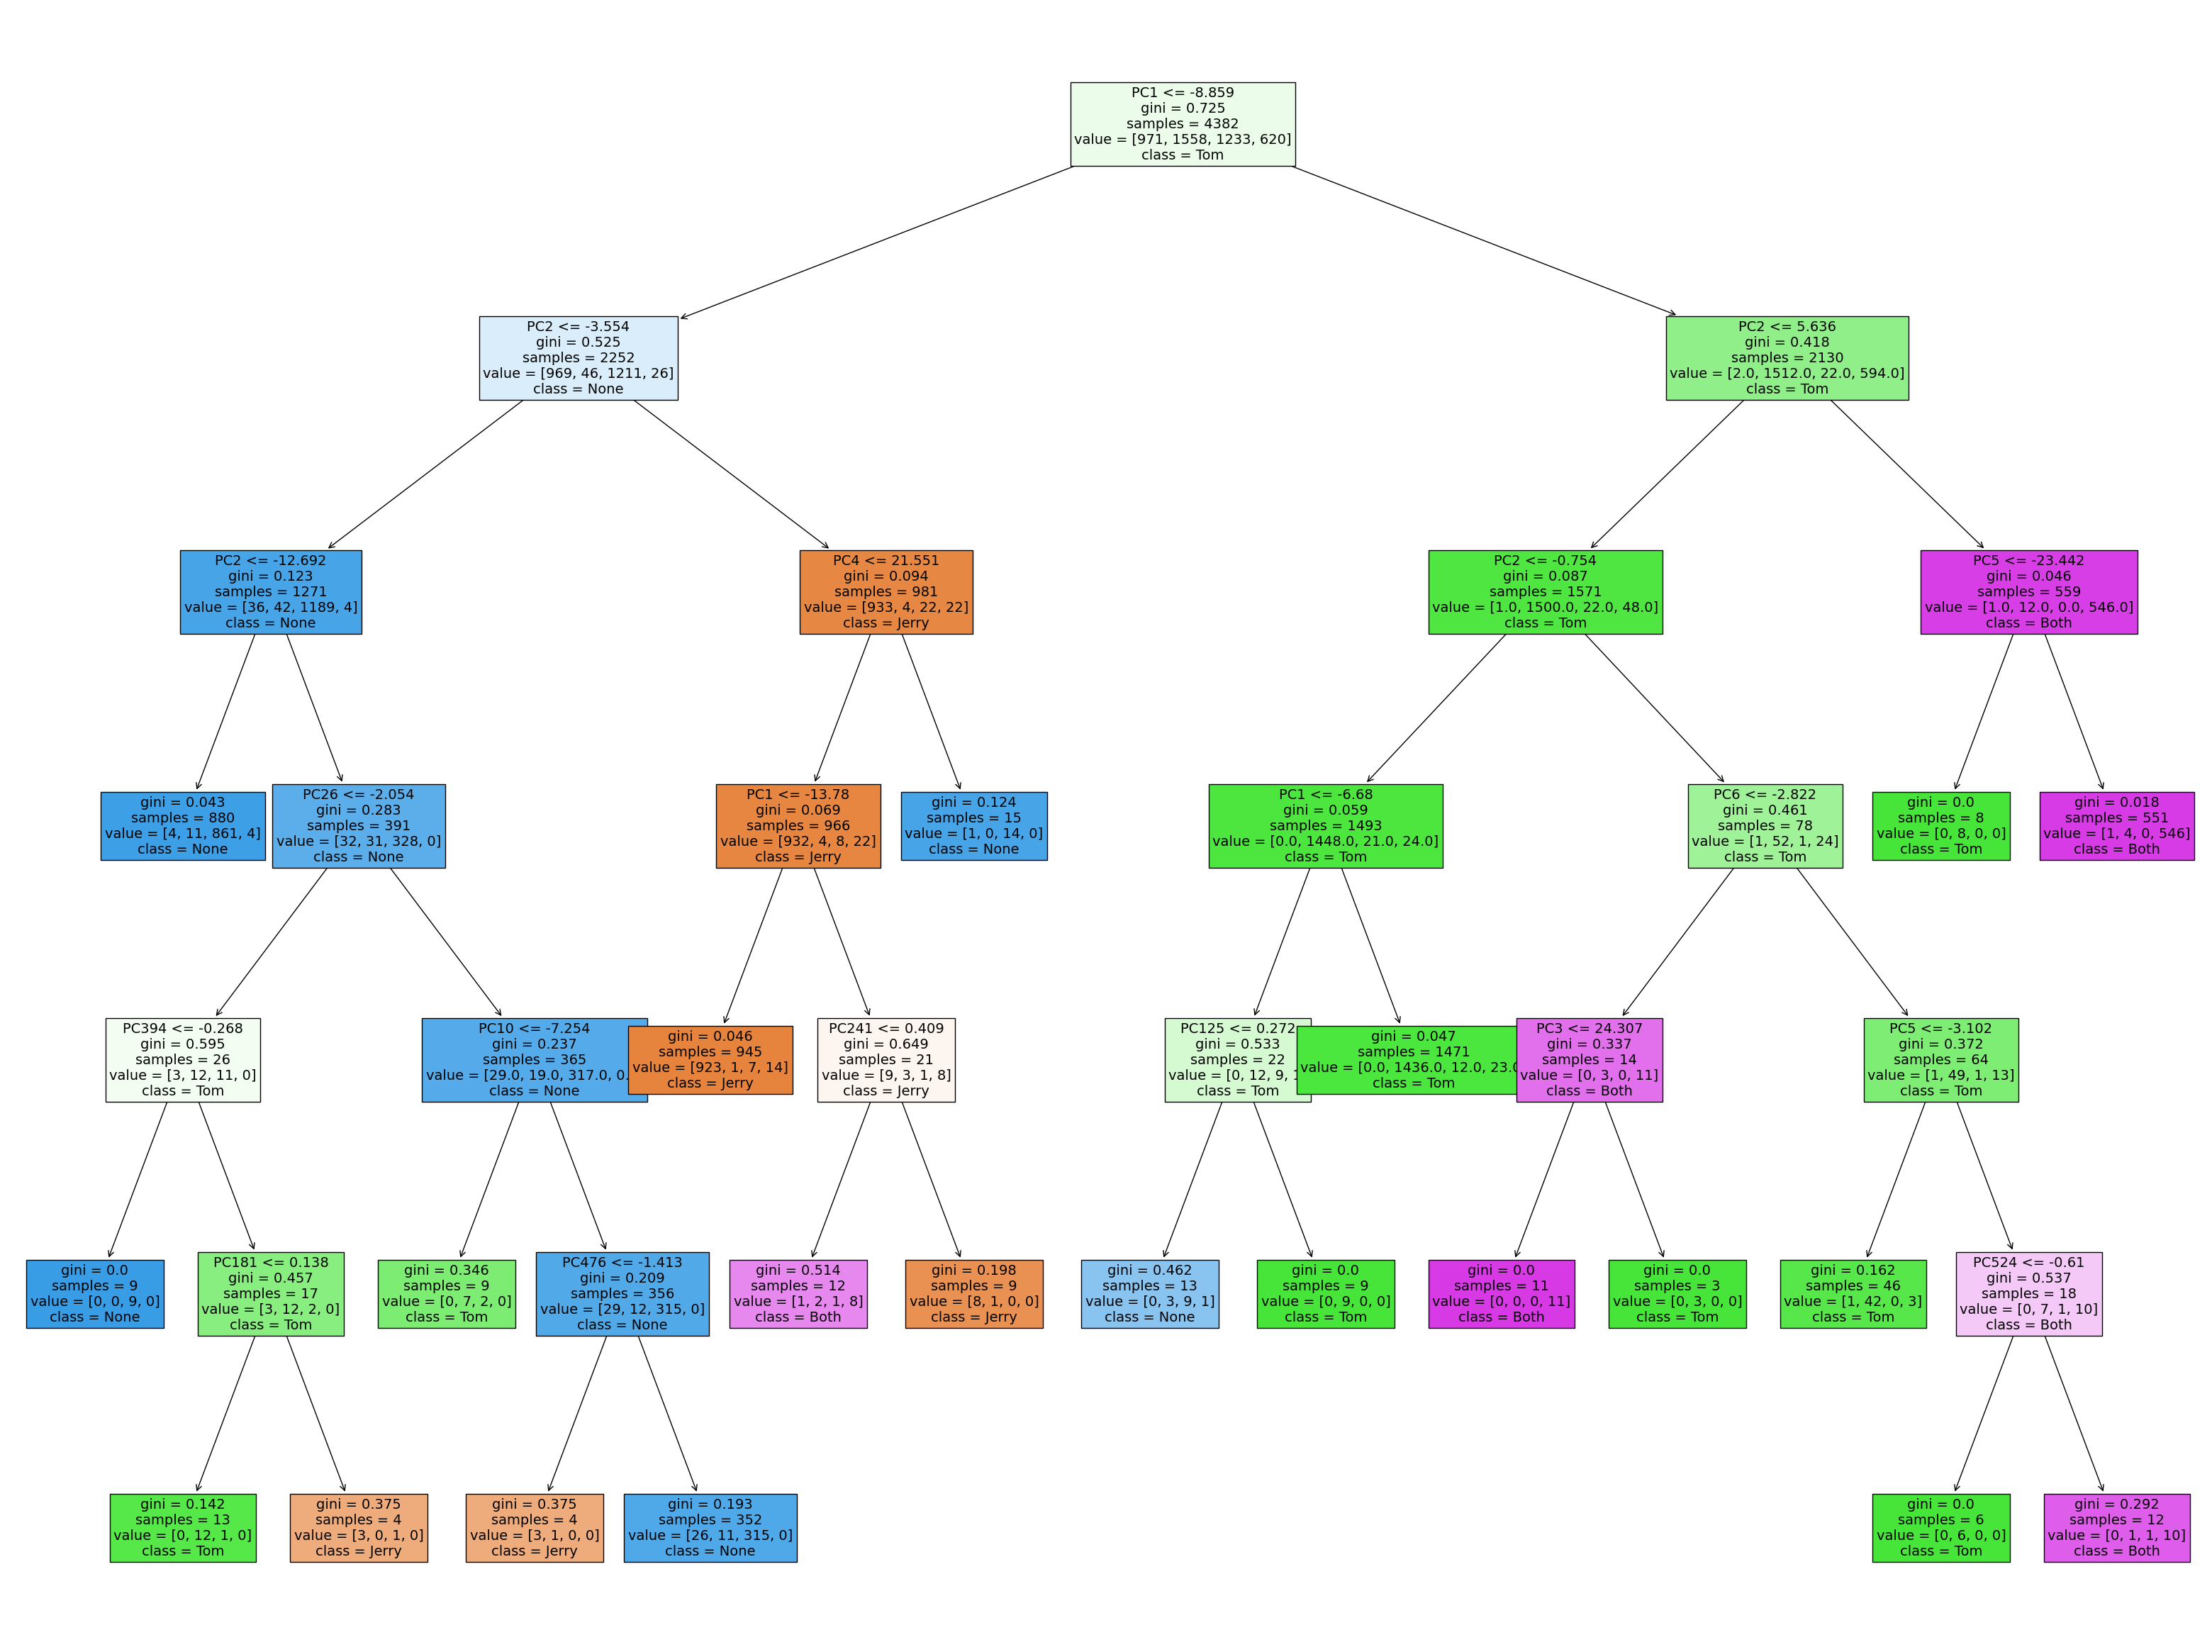

In [141]:
best_dt_classifier = DecisionTreeClassifier(**best_params)
best_dt_classifier.fit(X_train, y_train)

# Plot the decision tree with the best hyperparameters
plt.figure(figsize=(40, 30))  # Adjust the figure size as needed
plot_tree(best_dt_classifier, 
          feature_names= X_train.columns, 
          class_names= label_categories, 
          filled=True,
          fontsize=14)  # Adjust the fontsize parameter as needed
plt.show()

In [142]:
print("Hyperparameters:", best_params)
X_test = test_pca_df.drop(columns=['Label'])
y_test = test_pca_df['Label']

# Predict the labels for test data
y_pred = best_dt_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Hyperparameters: {'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 5}
Accuracy: 0.9443430656934306

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       269
           1       0.96      0.96      0.96       372
           2       0.92      0.95      0.93       295
           3       0.97      0.92      0.94       160

    accuracy                           0.94      1096
   macro avg       0.95      0.94      0.94      1096
weighted avg       0.94      0.94      0.94      1096


Confusion Matrix:
[[250   2  17   0]
 [  1 358   8   5]
 [  7   8 280   0]
 [  7   6   0 147]]


### Save in a csv the best Decision Tree Hyperparameters

In [144]:
best_params_df = pd.DataFrame.from_dict([best_params])
best_params_df.to_csv('./hyperparams/best_dt_params.csv', index=False)